## Lactate Discordance Project: Exploratory Analysis of Lactate in eICU-CRD by Illness Severity
### C.V. Cosgriff

This notebook extracts the maximum lactate in the first 24 hours for all patients in the eICU-CRD. After excluding patients with length of stay below four hours, those lacking data, and those under the age of 16, the lactate levels are grouped using deciles of the APACHE IVa score and then the distribution is plotted.

## 0 - Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dbname = 'eicu'
schema_name = 'eicu_crd'
query_schema = 'SET search_path TO ' + schema_name + ';'

con = psycopg2.connect(dbname=dbname)

## 1 - Extraction

Extract data from SQL database. Note we're using `labsfirstday` materialized view.

In [2]:
query = query_schema + '''
WITH apache AS (
    SELECT patientunitstayid, apachescore
           , actualhospitalmortality AS hospital_expire_flag
    FROM apachepatientresult
    WHERE apacheversion = 'IVa'
    AND apachescore != -1
    )
    
SELECT p.patientunitstayid, p.age, p.ethnicity
    , CASE  
        WHEN p.gender = 'Male' THEN 1
        ELSE 0
        END AS male_gender
        , la.LACTATE_min
        , la.LACTATE_max
        , ap.apachescore
        , ap.hospital_expire_flag
    , CASE
        WHEN p.unitdischargeoffset < 240 THEN 1
        ELSE 0
        END AS short_los
FROM patient p
LEFT JOIN labsfirstday la
    ON p.patientunitstayid = la.patientunitstayid
INNER JOIN apache ap
    ON p.patientunitstayid = ap.patientunitstayid;
'''

base_cohort = pd.read_sql_query(query, con)
display(base_cohort.head())
print(base_cohort.shape)

,patientunitstayid,age,ethnicity,male_gender,lactate_min,lactate_max,apachescore,hospital_expire_flag,short_los
0,141208,25,Caucasian,0,NaN,NaN,17,ALIVE,0
1,141233,81,Caucasian,0,NaN,NaN,66,ALIVE,0
2,141265,67,Caucasian,1,NaN,NaN,36,ALIVE,0
3,141288,61,Caucasian,0,0.9,3.2,33,ALIVE,0
4,141296,63,Caucasian,1,NaN,NaN,89,EXPIRED,0


(146696, 9)


Limit cohort to those who have a lactate, an APACHE IVa score, are age >16, and have a LoS greater than 4 hours.

In [3]:
base_cohort.loc[base_cohort.age == '> 89', 'age'] = 91.3
base_cohort.loc[base_cohort.age == '', 'age'] = np.nan
base_cohort.age = base_cohort.age.astype(float)
include = (base_cohort.loc[:, 'age']) > 16
include = include & (~pd.isna(base_cohort.loc[:, 'apachescore']))
include = include & (base_cohort.loc[:, 'apachescore'] >= 0)
include = include & (~pd.isna(base_cohort.loc[:, 'lactate_max']))
incldue = include & (base_cohort.loc[:, 'short_los'] == 0)
cohort = base_cohort.loc[include, ['patientunitstayid', 'apachescore', 'lactate_max']]

## 2 - Analysis

We then create deciles of the APACHE IVa score and assign each patient stay to a category. 

In [4]:
apache_category = pd.qcut(x=cohort.apachescore, q=np.arange(0, 1.1, 0.1), labels=np.arange(1, 11, 1))
cohort = cohort.assign(apache_category=apache_category)
cohort.loc[:, ['apache_category', 'lactate_max']].groupby('apache_category').describe()

lactate_max                                                 
                      count      mean       std  min  25%    50%   75%   max
apache_category                                                             
1                    5787.0  2.254961  1.972425  0.1  1.1  1.700  2.70  23.1
2                    5306.0  2.241786  1.921409  0.2  1.1  1.700  2.70  22.0
3                    5648.0  2.338376  1.935824  0.3  1.2  1.745  2.80  21.0
4                    6055.0  2.436892  2.098401  0.1  1.2  1.800  2.90  24.1
5                    5259.0  2.522508  2.133301  0.1  1.2  1.850  3.00  24.3
6                    5686.0  2.685649  2.419327  0.2  1.3  1.900  3.20  36.7
7                    5491.0  2.897343  2.562570  0.2  1.3  2.100  3.40  22.2
8                    5048.0  3.261440  3.036554  0.3  1.4  2.300  3.90  34.2
9                    5554.0  3.944566  3.654358  0.2  1.6  2.600  4.90  33.2
10                   5459.0  6.610738  5.538186  0.3  2.4  4.800  9.45  40.1

We can plot the above distributions.

/home/cvc/env/ML/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/cvc/env/ML/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Distribution of Maximum Lactate on Day 1, Grouped by APACHE IVa Decile')

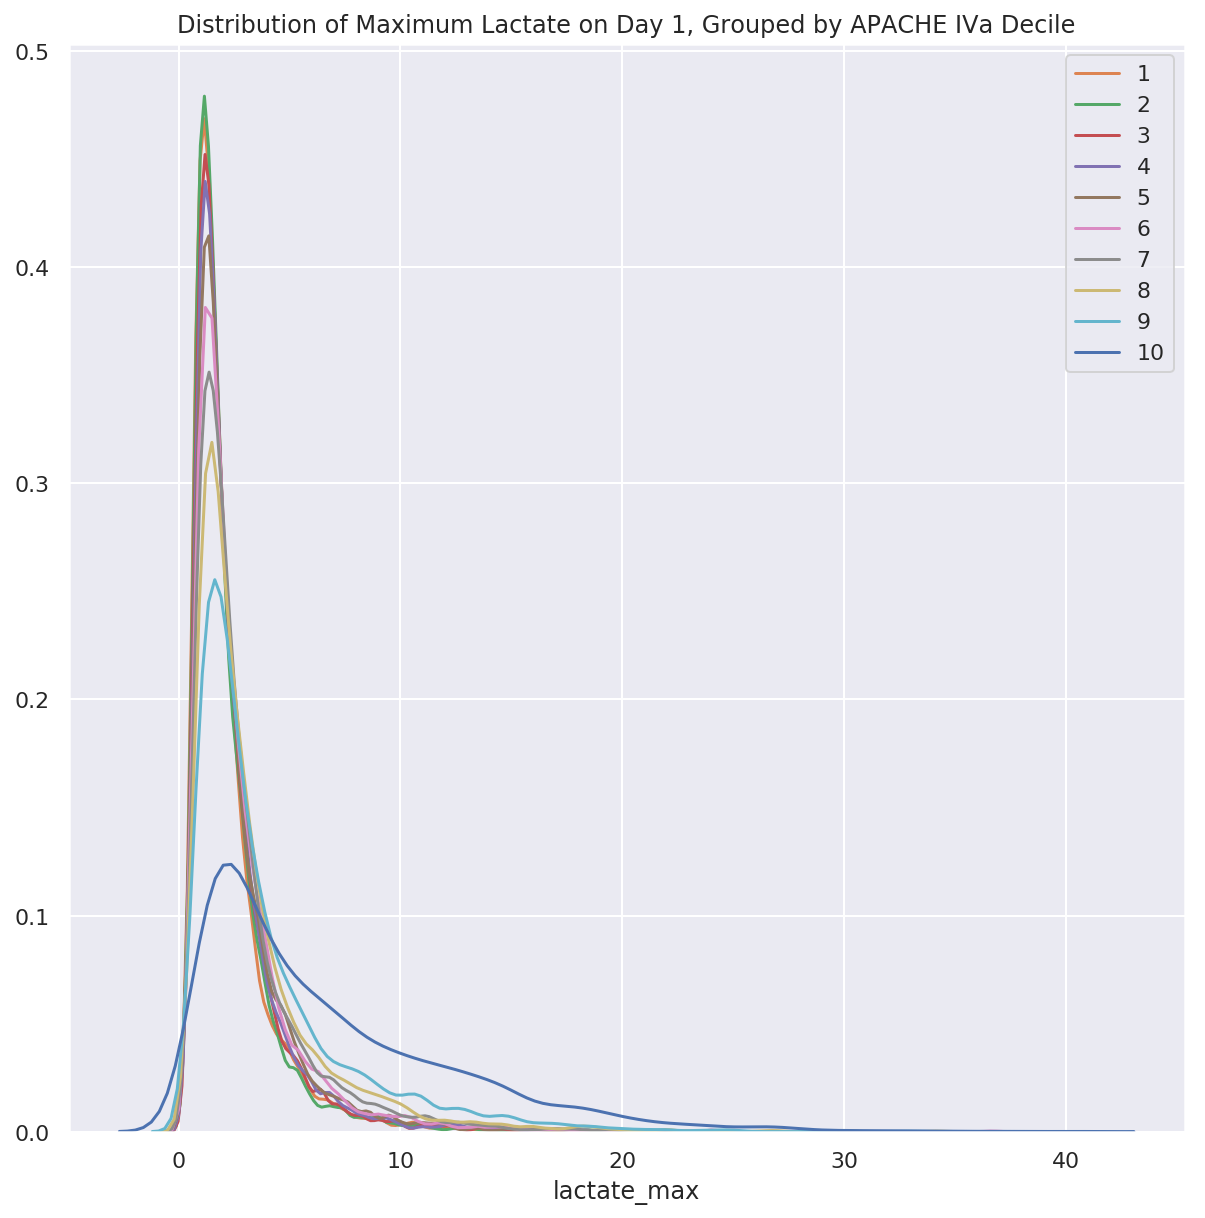

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
for i in range(11):
    sns.distplot(cohort.loc[cohort.apache_category == i, 'lactate_max'], hist=False, ax=ax, label=i)
plt.legend()
plt.title('Distribution of Maximum Lactate on Day 1, Grouped by APACHE IVa Decile')

We can also answer the question, "within each decile, how many patient's have a _normal_ lactate?"

Text(0, 0.5, 'Proportion with Normal Lactate')

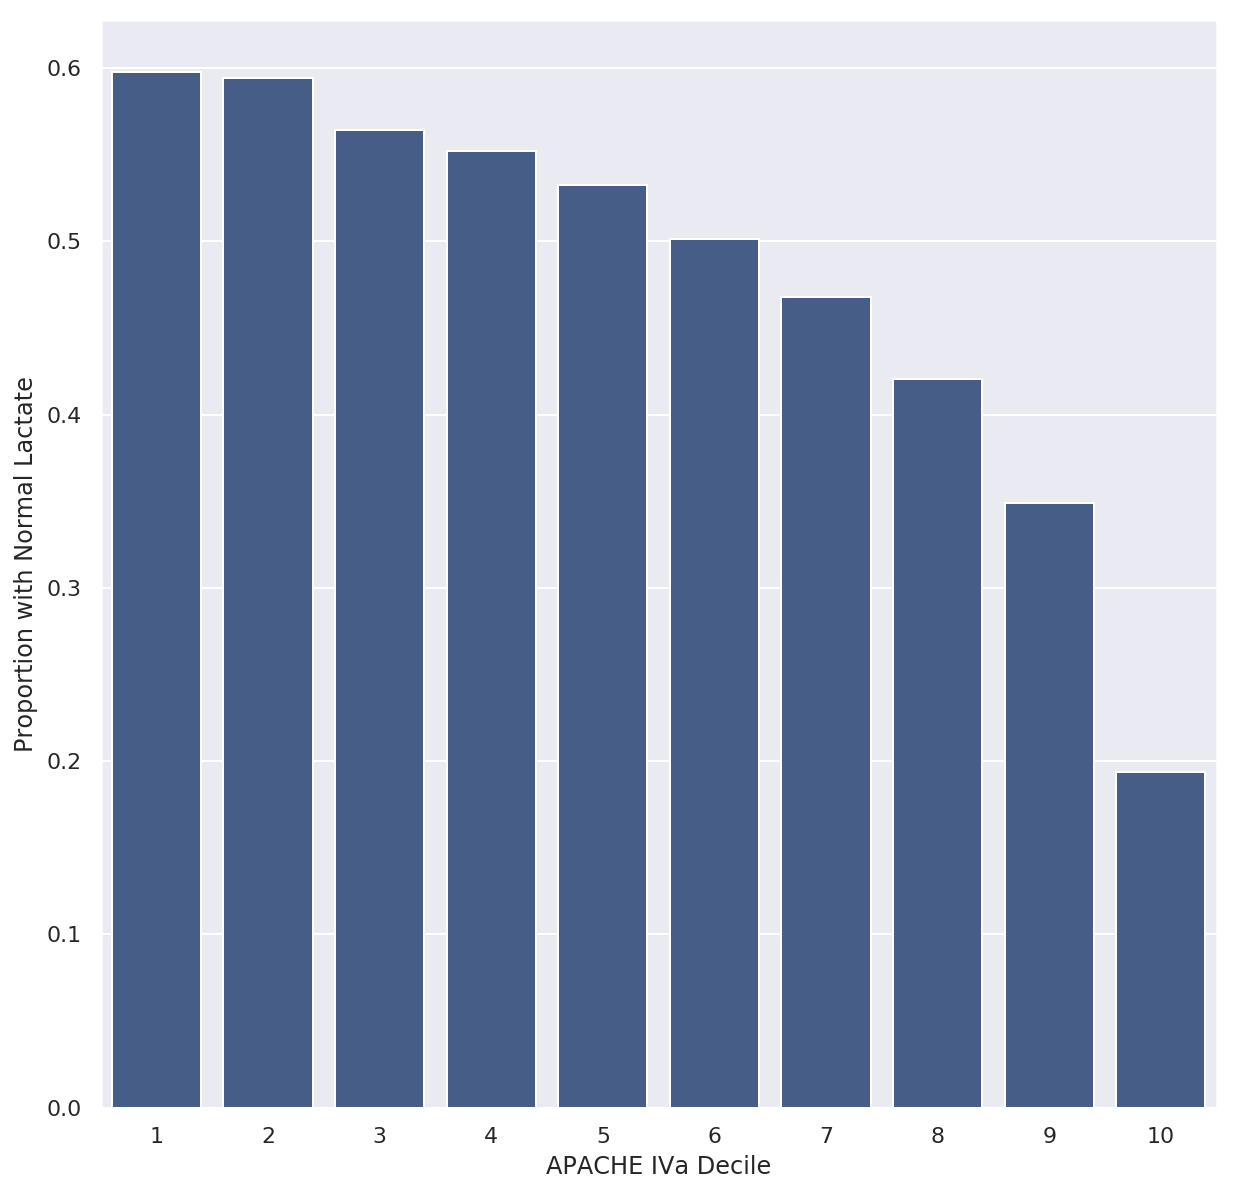

In [6]:
def normal_lactate(x):
    return (x < 2).mean()

normal_lac_prop = [normal_lactate(cohort.loc[cohort.apache_category == i, 'lactate_max']) for i in range(1,11)]

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=np.arange(1,11), y=normal_lac_prop, color=sns.xkcd_rgb['denim blue'], ax=ax)
plt.xlabel('APACHE IVa Decile')
plt.ylabel('Proportion with Normal Lactate')

With the analysis done, we close the database connection.

In [7]:
con.close()